In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchinfo import summary
import sys, os
import glob
import pickle
import matplotlib.pyplot as plt
import pathlib
import time

%matplotlib inline

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return {'data': dict[b'data'], 'labels': dict[b'labels']}

def combine_dicts(dicts: list)->dict:
    # keys: data, labels
    n = len(dicts)
    data, labels = dicts[0]['data'], dicts[0]['labels']
    for i in range(1,n):
        data = np.concatenate([data, dicts[i]['data']], axis=0)
        labels = labels + dicts[i]['labels']
    return {'data':data, 'labels':labels}

def array_to_rgb(arr: np.ndarray)->np.ndarray:
    # take an 1x3072
    # reshape to rgb: 32, 32, 3
    rgb = np.reshape(arr, (32, 32, 3), order='F').astype(dtype=np.float32)
    rgb = rgb / 255.
    # rotate by 90 degrees
    return np.rot90(rgb, k=1, axes=(1,0))

def show_image(arr: np.ndarray)->None:
    rgb_img = array_to_rgb(arr)
    print(rgb_img.shape)
    plt.figure(figsize=(2,2))
    plt.imshow(rgb_img)

def torch_from_numpy(arr: list)->torch.tensor:
    # convert to torch tensors
    #ndarrays = list(map(array_to_rgb, arr))
    tensors = [torch.from_numpy(item.copy()) for item in arr]
    return torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))

def make_dataset(d: dict)->list:
    data = list(map(array_to_rgb, d['data']))
    tensors = [torch.from_numpy(item.copy()) for item in data]
    tensors = torch.einsum('nhwc->nchw', torch.stack(tensors, dim=0))
    return list(zip(tensors, d['labels']))

def print_model_summary(model):
    print(summary(model.conv, input_size=(3,32,32)))
    print(summary(model.dense, input_size=(1, model.nf * 16)))

In [3]:
# conv layers of the network
class CNN(nn.Module):
    def __init__(self, channels, nf):
        super(CNN, self).__init__()
        # in: 3x32x32, out: nfx32x32
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=nf, kernel_size=3, stride=1, padding='same')
        # in: 32x32, out: 16x16
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # in: nfx16x16, out: nfx16x16
        self.conv2 = nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=3, stride=1, padding='same')
        # apply maxpool again
        # in: nfx8x8, out: nfx8x8
        self.conv3 = nn.Conv2d(in_channels=nf, out_channels=nf, kernel_size=3, stride=1, padding='same')
        #apply maxpool again
        self.bn_conv = nn.BatchNorm2d(nf)
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        #x = self.bn_conv(x)
        #x = self.dropout(x)
        x = self.maxpool(x)
        x = F.relu(x)
        
        return x

# dense layers of the network
class FCNN(nn.Module):
    def __init__(self, nf):
        super(FCNN, self).__init__()
        # in: nfx4x4, flatten and feed to linear layer
        self.fc1 = nn.Linear(nf*4*4, 100)
        self.bn_d1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 50)
        self.bn_d2 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, 10)
        self.bn_d3 = nn.BatchNorm1d(10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_d1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.bn_d2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.bn_d3(x)

        return x

# combined model
class MODEL(nn.Module):
    def __init__(self, channels, nf):
        super(MODEL, self).__init__()
        self.conv = CNN(channels, nf)
        self.dense = FCNN(nf)
        self.nf = nf
        self.channels = channels
    
    def forward(self, x):
        x = self.conv(x)
        x = x.flatten(1)
        x = self.dense(x)
        return x

In [4]:
# check if output shape as expected
test_model = MODEL(3,10)
test_input = torch.randn(size=(64,3,32,32))
output = test_model(test_input)
output.shape
#print_model_summary(test_model)

torch.Size([64, 10])

In [5]:
def train_model(model, device, train_loader, loss_criterion, optimizer, epoch):
    model.train()
    train_loss = 0
    total = 0
    total_acc = 0
    for batchidx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        #print(f'predictions: {predictions.shape}, target: {target.shape}')
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        total_acc += (correct/len(data))
        total += len(data)
    avg_acc = total_acc/len(train_loader)
    avg_loss = train_loss/total
    print(f"Train epoch: {epoch} [{(batchidx+1) * len(data)}/{len(train_loader.dataset)}\
          ({(100. * batchidx/len(train_loader)):.0f}%)]\tLoss: {avg_loss:.6f}\tAcc: {100. * avg_acc:.6f}%")
    return 100. * avg_acc

def test_model(model, device, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criterion(output, target).item()
            predictions = output.argmax(dim=1, keepdim=True)
            #print(f'predictions: {predictions.shape}, target: {target.shape}')
            correct += predictions.eq(target.view_as(predictions)).sum().item()
            total += len(data)
    test_loss /= total
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({100. * correct/total:.0f}%)")
    return 100. * correct/total

In [6]:
data_dir = "data/"
train_files = glob.glob('**/*_batch_*', recursive=True)
test_files = glob.glob('**/*test_batch*', recursive=True)
train_files = list(map(unpickle, train_files))
test_files = list(map(unpickle, test_files))
test = combine_dicts(test_files)
train = combine_dicts(train_files)
print(test['data'].shape)
print(train['data'].shape)

(10000, 3072)
(50000, 3072)


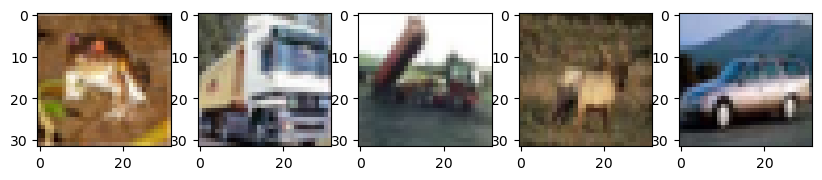

In [7]:
# plot sample images
sample_imgs = list(map(array_to_rgb, train['data'][0:5]))
_, axs = plt.subplots(1,5, figsize=(10,2))
axs = axs.flatten()
for img, ax in zip(sample_imgs, axs):
    ax.imshow(img)
plt.show()

(32, 32, 3)


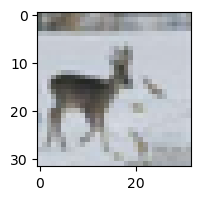

In [8]:
show_image(train['data'][20])

In [9]:
# convert to torch tensors
train_data = torch_from_numpy(list(map(array_to_rgb, train['data'])))
train_labels = np.array(train['labels'])
train_labels = torch.from_numpy(train_labels).reshape((train_labels.shape[0],-1))
print(f"train data shape: {train_data.shape}")
print(f"train labels shape: {train_labels.shape}")

train data shape: torch.Size([50000, 3, 32, 32])
train labels shape: torch.Size([50000, 1])


In [10]:
trainset = make_dataset(train)
testset = make_dataset(test)
batch_size = 64
learning_rate = 0.25
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = MODEL(3,32).to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(testset, shuffle=False, batch_size=batch_size, drop_last=True)
print(f"test size: {len(testset)}")
print(f"train size: {len(trainset)}")
print_model_summary(model)

test size: 10000
train size: 50000
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 4, 4]                64
├─Conv2d: 1-1                            [32, 32, 32]              896
├─MaxPool2d: 1-2                         [32, 16, 16]              --
├─Conv2d: 1-3                            [32, 16, 16]              9,248
├─MaxPool2d: 1-4                         [32, 8, 8]                --
├─Conv2d: 1-5                            [32, 8, 8]                9,248
├─MaxPool2d: 1-6                         [32, 4, 4]                --
Total params: 19,456
Trainable params: 19,456
Non-trainable params: 0
Total mult-adds (M): 8.02
Input size (MB): 0.01
Forward/backward pass size (MB): 0.34
Params size (MB): 0.08
Estimated Total Size (MB): 0.43
Layer (type:depth-idx)                   Output Shape              Param #
FCNN                                     [1, 10]                   --
├─Linear: 1-1                        

/home/codez/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987394225/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
epochs = 50
train_acc = []
test_acc = []
for epoch in range(1,epochs+1):
    train_acc.append(train_model(model, device, train_loader, loss_criterion, optimizer, epoch))
    test_acc.append(test_model(model, device, test_loader, loss_criterion))

Train epoch: 1 [49984/50000          (100%)]	Loss: 0.025110	Acc: 43.920054%
Test set: Average loss: 0.0208, Accuracy: 5454/9984 (55%)
Train epoch: 2 [49984/50000          (100%)]	Loss: 0.019717	Acc: 57.352353%
Test set: Average loss: 0.0201, Accuracy: 5666/9984 (57%)


KeyboardInterrupt: 

In [ ]:
pathlib.Path("saved_models").mkdir(exist_ok=True)
timestr = time.strftime("%Y%m%d-%H%M%S")
save_model_path = "saved_models/CIFAR10-"+timestr+".pth"
torch.save(model.state_dict(), save_model_path)